# Plotting variations of the BH mass distribution

both physical variations and SFRD variations

In [1]:
# %%file TestFig1.py
import os
import sys
import numpy as np
import h5py

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats

from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const

from importlib import reload  # Python 3.4+
# My own helper funcitons:
import MassDistHelperFunctions as mfunc
reload(mfunc)

#########################################
# Nice little progressbar script 
# to know how far you are with bootstrapping
#########################################
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()


######################################
## locations
proj_dir    =  '/n/home04/lvanson/LowMBH_peak/'#'Users/lieke/surfdrive/Documents/LowMBH_peak/'#
data_dir    = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/'

sim_save_str = ''

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Mass dist function

In [48]:


# Distribution plot function
def plot_mass_distribution(sim_dir = data_dir, sim_sets = ['alphaCE1.0'], x_key = 'M_moreMassive', dco_flavour = "BBH", 
                          bins = np.arange(1,50,1),  z_bin_edges = [0,0.5],plot_str = 'stable', dcomask_key = 'DCOmask',
                           linestyles = ['-','-', '-', '-', '-.', '-', ':', '--', '-.'], average_rate = False,
                           log = True, logx = False, kde_width = 0.07, show_hist = False, show_KDE = True, plot_posteriors = False,
                           show_rise_feature=True, GWTC_3 = True, rate_key =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                           labels = ['$\mathrm{\ Stable \ MT \ channel \  (BBH)} $'+'\n'+'$\mathcal{R}_{0.2}= \ $'],
                           save_plot=False, x_lim=(1,15), y_lim = (1e-2,50), bootstrap = False, bootstraps = 50,
                          colors = ['#e388b0'], save_name = 'testFiducial.png',
                           xlabel = r'$\mathrm{More \ massive \ component}, \  M_{\mathrm{primary}} \ \rm [M_{\odot}]$', 
                           ylabel = r'$\frac{d\mathcal{R}}{dM_{\mathrm{primary}}} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                         leg_args = {'loc':'lower right', 'fontsize':'22', 'title':'', 'framealpha':1.0}, 
                           leg1_args ={'loc':'upper right','bbox_to_anchor':(1.01,1.01), 'fontsize':'22', 'framealpha':1.0}):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            sim_dir              --> [string] Location of data
            dco_flavour          --> [string] Which favour of dco do you want ["BBH", "NSNS", "BHNS", "BBH_BHNS"]

        Returns:
         plot

    """
   
    #########################################
    mass_binw = np.diff(bins)[0]
    plot_lines = []
    leg_labels = []

    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (12, 9))
    
        
    if show_rise_feature:      
        ####################
        # Farah+ 2021
        rise_range = np.arange(6-1.4,6+2.4,0.1)
        ax.fill_between(rise_range,y1= np.full(len(rise_range),1e-3),y2= np.full(len(rise_range),1e2),
                        zorder = 0, label = '$\mathrm{Possible \ rise \ in \ GW \ data }$'+'\n'+'$\mathrm{(Farah \ et \ al. \ 2021)}$',
                        alpha=0.14, color='#1f78b4'  )#,color='#1f78b4')
        
        
    ################################################
    # GWTC-3 Powerlaw + Peak Mass distribution
    ################################################ 
    if GWTC_3:
        color_plpeak =  '#e0e0e0'#'#1f78b4'
        if not os.path.isfile(proj_dir+'/output/GWTC3_PplusPeak.txt'):
            #################################################
            ## grab Powerlaw + Peak data from O3
            #################################################  
            input_fname = proj_dir+'/output/o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
            mass_1 = np.linspace(2, 100, 1000)
            mass_ratio = np.linspace(0.1, 1, 500)
            with h5py.File(input_fname, "r") as f:
                mass_ppd = f["ppd"]
                mass_lines = f["lines"]
                mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
                mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
                mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
                np.savetxt(proj_dir+'/output/GWTC3_PplusPeak.txt', np.c_[mass_1, mass_1_ppd, mass_1_lower, mass_1_upper])
        else:
            mass_1, mass_1_ppd, mass_1_lower, mass_1_upper = np.loadtxt(proj_dir+'/output/GWTC3_PplusPeak.txt', unpack = True)
        ##############################
        # plot the max posterior and the 95th percentile
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color='grey', zorder=1, label="$\mathrm{GWTC3, \ (Power \ law \ + \ Peak) }$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.9,color=color_plpeak,edgecolor = 'grey',zorder=0)

        legend1 = plt.legend(**leg1_args)

    ####################
    # Add legend for ligo data
    legend1 = plt.legend(title="$\mathrm{Features \ in \ GWTC-3}$", **leg1_args)  
    nplot = 0
    
    ################################################
    # My Simulations
    ################################################
    for sim, sim_set in enumerate(sim_sets):
        ####################################################
        ### ## Reading file ##
        File_location = sim_dir +'/'+sim_set+'/output/COMPAS_Output_wWeights.h5'
#         DCO, DCO_mask  = mfunc.read_data(loc = File_location, DCO_type = "BBH", rate_key = '', read_SFRD = False
        ####################################################
        ### Loop over SFRD
        DCO, rateDCO_mask, DCO_mask, rate_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0 = mfunc.read_data(loc = File_location, read_SFRD = True, dcomask_key = dcomask_key, DCO_type = dco_flavour, rate_key = rate_key)
        DCO['q_ZAMS']  =  DCO['Mass@ZAMS(2)']/DCO['Mass@ZAMS(1)']
        HG_HG_MT       =  DCO['experiencedHGHG_MT'] == True
        
        # # # # # # # # # # # # # # # # # # 
        #first bring it to the same shape as the rate table
        merging_BBH    = DCO[rateDCO_mask]
        #then apply the additional mask based on your prefs
        #HG_HG_MT       = merging_BBH['experiencedHGHG_MT'] == True
        merging_BBH    = merging_BBH[rate_mask]# * HG_HG_MT]
        
        #########################################
        # X value and weight
        x_vals              = merging_BBH[x_key]
        # # # # # # # # # # # # # # # # # # 
        ## Calculate average rate density per z-bin, or take rate at z = 0.2
        if average_rate:
            crude_rate_density = mfunc.get_crude_rate_density(intrinsic_rate_density[rate_mask,:], redshifts[:len(intrinsic_rate_density[0,:])+1], z_bin_edges) #
            weights            = crude_rate_density[:,0]
            #ax.set_title('average rate %s'%str(z_bin_edges))
        else:
            i_redshift         = np.where(redshifts == 0.2)[0][0]
            print('i_redshift', i_redshift, '==> z =', redshifts[i_redshift])
            weights            = intrinsic_rate_density[rate_mask,:]
            weights            = weights[:, i_redshift]
            #ax.set_title('Rate at z=0.2')


        ################################## 
        ### ## Split by channel  ##
        if 'CE_Event_Counter' in merging_BBH.keys():
            CE_count_key = 'CE_Event_Counter'
        else:
            CE_count_key = 'CE_Event_Count'

        # CE channel
        BBH_CEchannel     = merging_BBH[merging_BBH[CE_count_key] >0]
        CEchannel_weights = weights[merging_BBH[CE_count_key] >0]
        # stable RLOF channel
        BBH_stablechannel     = merging_BBH[merging_BBH[CE_count_key] == 0]
        stablechannel_weights = weights[merging_BBH[CE_count_key] == 0]

        # # # # # # # # # # # # # # # # # # 
        ## Print the rate of BBH and BHNS in line with LVK convention (table II from GWTC-3 pop paper)
        BBH_bool  = np.logical_and(BBH_stablechannel['Stellar_Type(1)'] == 14, BBH_stablechannel['Stellar_Type(2)'] == 14)
        BHNS_bool = np.logical_or(np.logical_and(BBH_stablechannel['Stellar_Type(1)'] == 13, BBH_stablechannel['Stellar_Type(2)'] == 14),
                                  np.logical_and(BBH_stablechannel['Stellar_Type(1)'] == 14, BBH_stablechannel['Stellar_Type(2)'] == 13))

        # put differrent rates in a list
        tables = [BBH_CEchannel, BBH_stablechannel, merging_BBH]
        WEIGHTS_list = [CEchannel_weights, stablechannel_weights, weights]

        ################################################
        # Plot Stable and CE channel seperately
        for i, table in enumerate(tables):
            if len(table) == 0:
                #print(labels[i], 'Table is empty!!')
                continue
            # Select which ones to plot
            if plot_str == 'CE':
                if i != 0: continue
            elif plot_str == 'stable':
                if i != 1: continue
            elif plot_str == 'All':
                if i != 2: continue
            elif plot_str == 'channels':
                if i == 2: continue
            #########################################
            # X value and weight
            x_vals                = table[x_key]
            m_Weight              = WEIGHTS_list[i]

            ########################
            # Get the Hist    
            hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
            y_vals = hist/mass_binw

            center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
            min_xkde    = 0.1

            # And the KDE
            kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
            binwidth = np.diff(bin_edge)

            # Plot the Hist 
            if show_hist:
                print('nplot', nplot, '\n')
                plot_lines.append(ax.plot(center_bins, y_vals, label = None,
                                          alpha=1.0, lw = 3.5, zorder = i, color= colors[nplot], ) ) 
                                
                ########################
                # Bootstrap   
                if bootstrap:
                    indices = np.arange(len(x_vals))
                    hist_vals = np.zeros((bootstraps, len(center_bins))) 
                    for b in progressbar( range(len(hist_vals)), "Bootstrapping :"):
                        boot_index      = np.random.choice(indices, size=len(indices), replace=True)
                        hist_vals[b], _ = np.histogram(x_vals[boot_index], bins=bins, weights=m_Weight[boot_index],density=False)
                    
                    # calculate 90% tile
                    y_vals = hist_vals/mass_binw
                    if logx:
                        y_vals = y_vals*center_bins
                    percentiles = np.percentile(y_vals, [10., 90.], axis=0)
                    print('nplot',nplot, 'len(colors)', len(colors))
                    ax.fill_between(center_bins, percentiles[0],percentiles[1], alpha=0.4, color=colors[nplot], zorder = 0) # 1-sigma #x_KDE
                                    
            ########################
            # Plot KDE
            if show_KDE:
                print('nplot', nplot, '\n')
                x_KDE = np.arange(min_xkde,50.,0.1)
                KDEy_vals =  kernel(x_KDE)*sum(hist) #re-normalize the KDE
                if logx:
                    KDEy_vals = x_KDE * KDEy_vals # plot m dr/dm
                plot_lines.append(ax.plot(x_KDE, KDEy_vals, label = '', 
                                        color=colors[nplot], lw= 5,  zorder =i+1,ls = linestyles[nplot])) #ls = linestyles[SFRD_i])                    

                ########################
                # Bootstrap   
                if bootstrap:
                    indices = np.arange(len(x_vals))
                    hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
                    
                    for b in progressbar( range(len(hist_vals)), "Bootstrapping :"):
                        boot_index = np.random.choice(indices, size=len(indices), replace=True)
                        kernel         = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights = m_Weight[boot_index])
                        Hist, _        = np.histogram(x_vals[boot_index], bins=bins, weights = m_Weight[boot_index], density=False)
                        hist_vals[b]   = kernel(x_KDE)*sum(Hist)
                    # 90th %-tile
                    y_vals = hist_vals
                    if logx:
                        y_vals = y_vals*center_bins
                    percentiles = np.percentile(y_vals, [10., 90.], axis=0)
                    ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors[nplot], zorder = 2) # 1-sigma
               

            leg_labels.append(labels[nplot]+'$%s$'%(np.round(np.sum(m_Weight),1)) + r' $\rm{Gpc^{-3} yr^{-1}}$')
            nplot += 1
            

    #########################################
    # NS bound
    ax.fill_between(np.arange(0,2.6, 0.1), y1 = 1e-3, y2 = 5e3, lw = 3, color = 'none', edgecolor = 'none', hatch = '/', alpha = 0.5, zorder = 20) ##e0e0e0
    ax.axvline( x = 2.5, c = 'grey',ls='--', lw = 5, zorder = 10)
    ax.text(0.02, 0.5, '$\mathrm{NS \ Formation}$', va = 'center', #bbox=dict(facecolor='#e8e8e8', edgecolor='none', pad=8), 
            transform=ax.transAxes, rotation = 90, zorder = 21)

    
    #########################################
    # plot values
    ax.grid(True, dashes=(1, 3))
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    #####
    # add legend
    leg = ax.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  
                **leg_args)
    leg.set_zorder(102)
    if np.logical_or(plot_posteriors, show_rise_feature):
        ax.add_artist(legend1)
        legend1.set_zorder(103)

    s = ['$[%s \leq z < %s]$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1)]    

    ax.set_xlabel(xlabel, fontsize = 35)
    ax.set_ylabel(ylabel, fontsize = 35)
    if log:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
        
    if save_plot:
        plt.savefig(proj_dir+'/plots/'+save_name , bbox_inches='tight')

    plt.show()


    

# Figure one 

sum(rateDCO_mask) 1835145
len(DCO[rateDCO_mask]) 1835145 np.shape(intrinsic_rate_density) (1835145, 200)
i_redshift 4 ==> z = 0.2
nplot 0 

Bootstrapping :[############################################################] 50/50


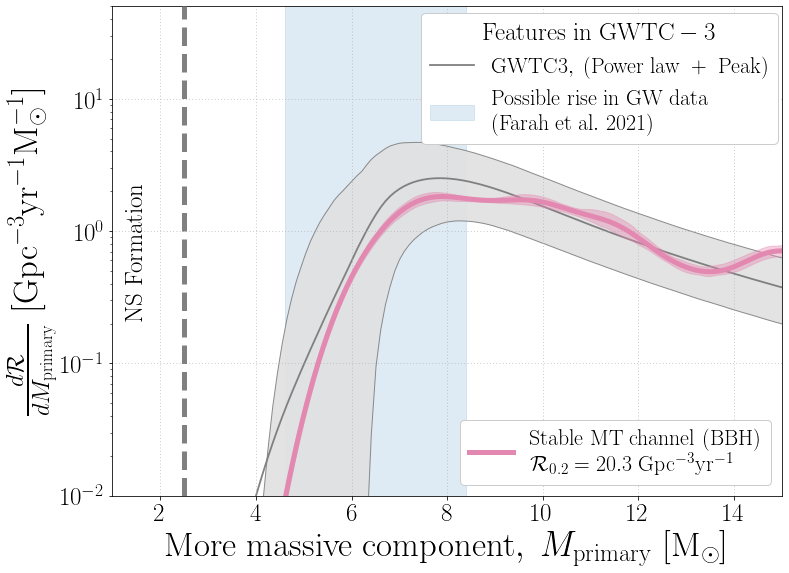

In [52]:
plot_mass_distribution(sim_dir = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/'+'v02.26.03/N1e7Grid_BBH_BHNS_optimized/',\
                       sim_sets =  ['faccTHERMALzetaHG6.5RemMassFRYER2012SNDELAYED'],
                       rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05'+'_a0.02_b1.48_c4.45_d5.9' +'_zBinned',\
                       bootstrap=True, bootstraps = 50, save_plot=True, save_name = 'BBH_Fiducial_betaTHERMzeta6.5FryerDelayed.pdf')

# 


sum(rateDCO_mask) 120296
len(DCO[rateDCO_mask]) 120296 np.shape(intrinsic_rate_density) (120296, 200)
i_redshift 4 ==> z = 0.2
nplot 0 

Bootstrapping :[############################################################] 5/5
nplot 0 len(colors) 1


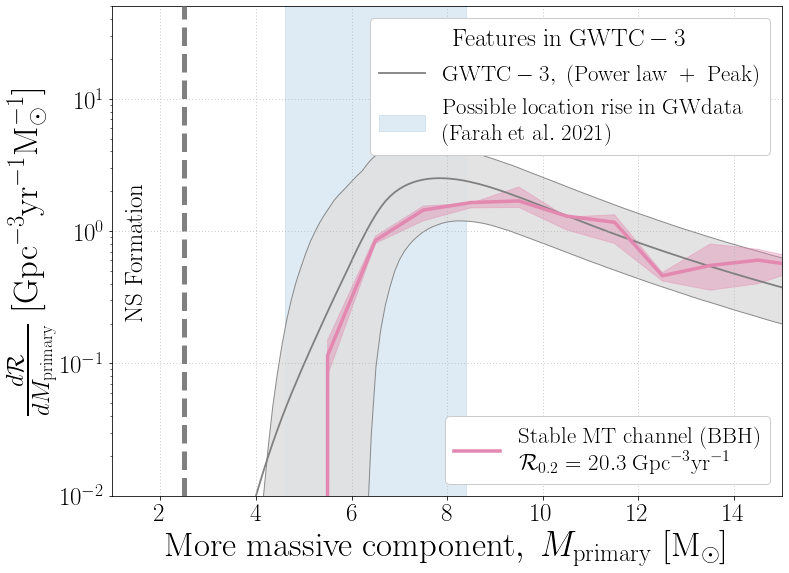

In [37]:
plot_mass_distribution(sim_dir = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/'+'v02.26.03/N1e6Grid_BBH_BHNS_optimized/',\
                       sim_sets =  ['faccTHERMALzetaHG6.5RemMassFRYER2012SNDELAYED'],
                       rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05'+'_zBinned',\
                       show_hist = True, show_KDE = False,
                       bootstrap=True, bootstraps = 5, save_plot=False, save_name = 'BBH_Fiducial_betaTHERMzeta6.5FryerDelayed_hist.pdf')

# '_a0.02_b1.48_c4.45_d5.9' +
